# Configure Cluster Module Params

This notebook should be used as a test for ensuring correct cluster parameters before cluster processing.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for cluster module

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [2]:
from pathlib import Path

import yaml
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from lib.shared.file_utils import get_filename
from lib.cluster.cluster_eval import plot_cell_histogram
from lib.cluster.phate_leiden_clustering import (
    phate_leiden_pipeline,
    plot_phate_leiden_clusters,
)
from lib.cluster.benchmark_clusters import perform_resolution_thresholding
from lib.cluster.scrape_benchmarks import (
    generate_string_pair_benchmark,
    generate_corum_group_benchmark,
)
from lib.shared.configuration_utils import CONFIG_FILE_HEADER

In [3]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
    ROOT_FP = Path(config["all"]["root_fp"])

## <font color='red'>SET PARAMETERS</font>

### Cluster preprocessing

- `MIN_CELL_CUTOFFS`: Minimum cells for each gene to be used in clusetering analysis. More cells per gene increases confidence, but some dataset types (ex mitotic) may have an inherently low number of cells for a particular perturbation.

In [4]:
MIN_CELL_CUTOFFS = {"mitotic": 0, "interphase": 3, "all": 3}

PERTURBATION_NAME_COL = config["aggregate"]["perturbation_name_col"]

Cell count distribution for: mitotic
Number of genes below cutoff: 0
[]


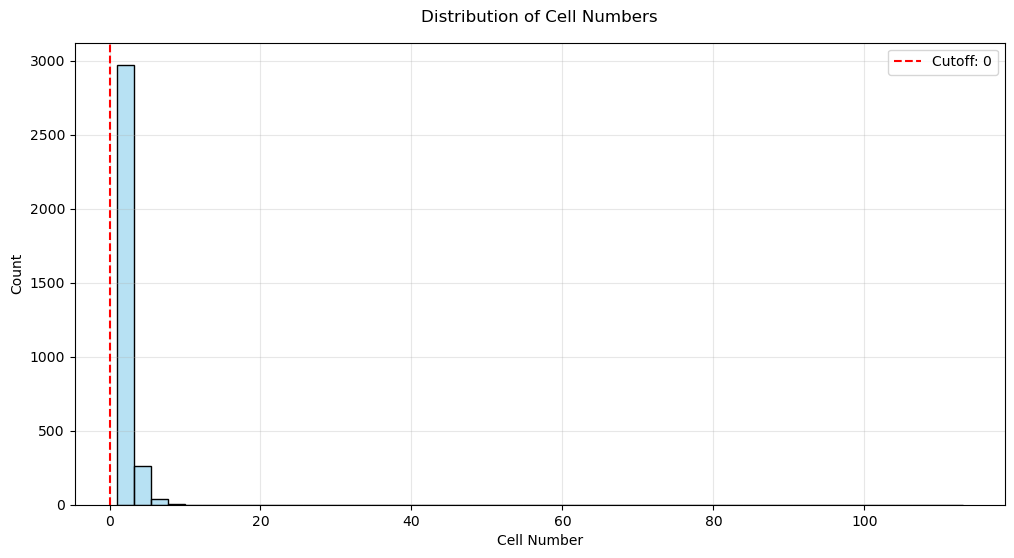

In [5]:
for cell_class, min_cell_cutoff in MIN_CELL_CUTOFFS.items():
    # load and clean relevant dataset
    aggregated_data_path = (
        ROOT_FP
        / "aggregate"
        / "tsvs"
        / get_filename({"cell_class": cell_class}, "aggregated", "tsv")
    )
    aggregated_data = pd.read_csv(aggregated_data_path, sep="\t")

    # show cell count distribution
    print(f"Cell count distribution for: {cell_class}")
    plot_cell_histogram(aggregated_data, min_cell_cutoff, PERTURBATION_NAME_COL)
    plt.show()

    break  # TODO: REMOVE

## <font color='red'>SET PARAMETERS</font>

### Benchmark Generation

- `STRING_PAIR_BENCHMARK_FP`: Path to save and access STRING pair benchmark.
- `CORUM_GROUP_BENCHMARK_FP`: Path to save and access CORUM group benchmark.

**Note**: We use the following benchmark schemas:
- Pair Bechmark: `gene_name` column for gene matching with a cluster gene (or does not exist in cluster genes); `pair` column with a pair ID. Used to benchmark known pair relationships in generated cluster.
- Group Bechmark: `gene_name` column for gene matching with a cluster gene (or does not exist in cluster genes); `group` column with a group ID. Used to benchmark known group relationships in generated cluster, where a group represents genes involved in a pathway, protein complex, etc.

In [ ]:
STRING_PAIR_BENCHMARK_FP = "config/benchmark_clusters/string_pair_benchmark.tsv"
CORUM_GROUP_BENCHMARK_FP = "config/benchmark_clusters/corum_group_benchmark.tsv"

In [7]:
string_pair_benchmark = generate_string_pair_benchmark(aggregated_data, "gene_symbol_0")
Path(STRING_PAIR_BENCHMARK_FP).parent.mkdir(parents=True, exist_ok=True)
string_pair_benchmark.to_csv(STRING_PAIR_BENCHMARK_FP, sep="\t", index=False)
display(string_pair_benchmark)

corum_group_benchmark = generate_corum_group_benchmark()
Path(CORUM_GROUP_BENCHMARK_FP).parent.mkdir(parents=True, exist_ok=True)
corum_group_benchmark.to_csv(CORUM_GROUP_BENCHMARK_FP, sep="\t", index=False)
display(corum_group_benchmark)

Fetching STRING data...
Completed. Total interactions: 117118
Fetching UniProt data...
Completed. Total entries: 20457


,gene_name_variants,pair,gene_name
0,ARF5,1,ARF5
1,RAB11FIP3 ARFO1 KIAA0665,1,RAB11FIP3
2,M6PR MPR46 MPRD,2,M6PR
3,GGA3 KIAA0154,2,GGA3
4,M6PR MPR46 MPRD,3,M6PR
...,...,...,...
225791,LYL1 BHLHA18,117116,LYL1
225792,RFX7 RFXDC2,117117,RFX7
225793,RFXANK ANKRA1 RFXB,117117,RFXANK
225794,RFX7 RFXDC2,117118,RFX7


Fetching CORUM data...


/lab/barcheese01/rkern/miniconda3/envs/brieflow_agg_overhaul_env/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mips.helmholtz-muenchen.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Completed. Total complexes: 5366


,gene_name,group
0,BCL6,0
1,HDAC4,0
2,BCL6,1
3,HDAC5,1
4,BCL6,2
...,...,...
18335,QRFPR,5363
18336,LRP4,5364
18337,SOST,5364
18338,HCRTR2,5365


## <font color='red'>SET PARAMETERS</font>

### Cluster Testing

- `TEST_CELL_CLASS`: Cell class to test clustering on. Usually `all` or cell class of interest.
- `LEIDEN_RESOLUTIONS`: Resolutions for testing Leiden clustering. Higher means more clusters.

In [8]:
TEST_CELL_CLASS = "all"

LEIDEN_RESOLUTIONS = [2, 5, 10]
# Can do more clusters for higher plot resolution
# LEIDEN_RESOLUTIONS = [0.5, 1, 2, 5, 10, 20]

CONTROL_KEY = config["aggregate"]["control_key"]

Creating clusters for resolution: 2
Creating clusters for resolution: 5
Creating clusters for resolution: 10


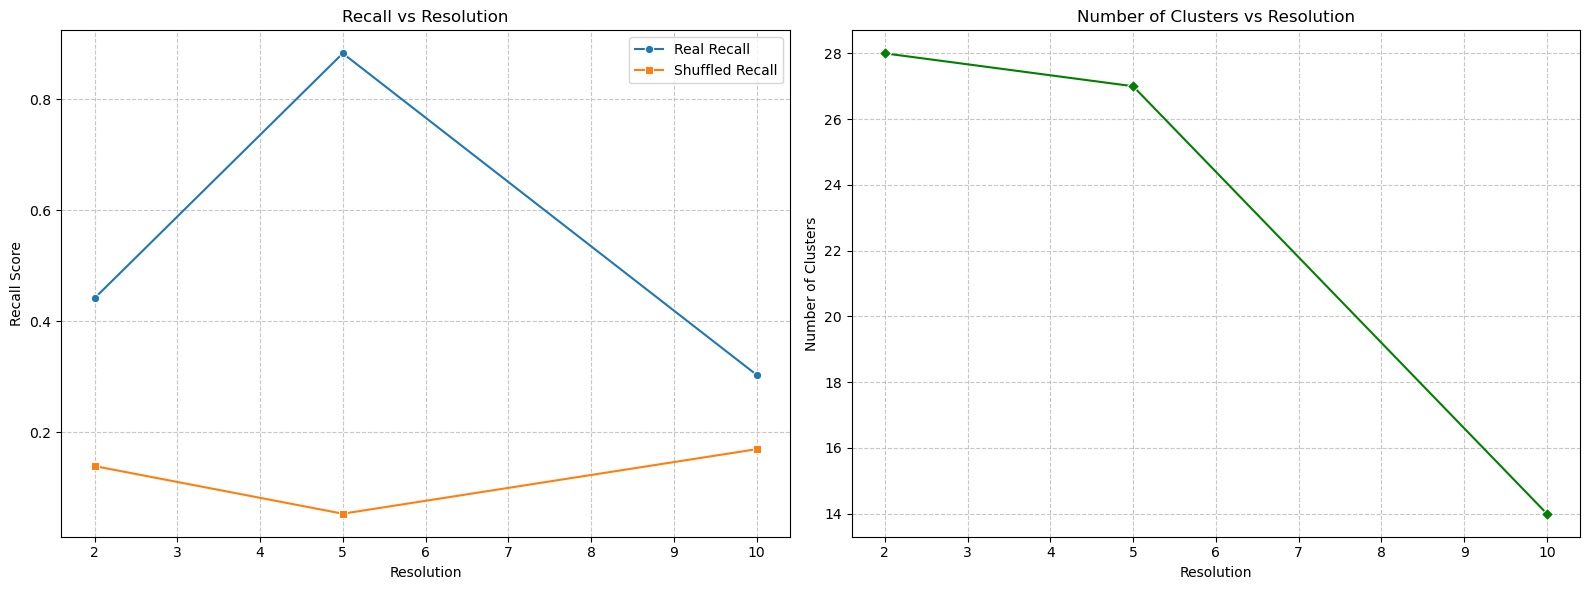

In [9]:
# TODO: update to real paths
# aggregated_data_path = (
#     ROOT_FP
#     / "aggregate"
#     / "tsvs"
#     / get_filename({"cell_class": TEST_CELL_CLASS}, "aggregated", "tsv")
# )
# aggregated_data = pd.read_csv(aggregated_data_path, sep="\t")
aggregated_data_path = "/lab/barcheese01/rkern/aggregate_overhaul/brieflow-analysis/analysis/analysis_root/aggregate/parquets/CC-all__aggregated.parquet"
aggregated_data = pd.read_parquet(aggregated_data_path)

# create baseline data by shuffling columns independently
shuffled_aggregated_data = aggregated_data.copy()
feature_start_idx = shuffled_aggregated_data.columns.get_loc("PC_0")
feature_cols = shuffled_aggregated_data.columns[feature_start_idx:]
for col in feature_cols:
    shuffled_aggregated_data[col] = np.random.permutation(shuffled_aggregated_data[col].values)

resolution_thresholding_df, resolution_thresholding_fig = perform_resolution_thresholding(aggregated_data, shuffled_aggregated_data, LEIDEN_RESOLUTIONS)

## <font color='red'>SET PARAMETERS</font>

### Cluster Generation

- `LEIDEN_RESOLUTION`: Final resolution for creating Leiden clusters.

In [ ]:
import pandas as pd
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests


def fisher_pathway_enrichment(cluster_df, pathway_df, filter_nontargeting=True):
    """Perform Fisher's exact test for pathway enrichment across clusters.

    Args:
        cluster_df (pd.DataFrame): DataFrame containing 'gene_symbol_0' and 'cluster'.
        pathway_df (pd.DataFrame): DataFrame containing 'gene_name_variants' and 'pathway'.
        filter_nontargeting (bool): Whether to filter out 'nontargeting' genes.

    Returns:
        pd.DataFrame: Results with enriched pathways per cluster (FDR < 0.05).
    """
    # Get all unique genes in the cluster_df
    cluster_genes = set(cluster_df["gene_symbol_0"])

    cluster_genes_in_pathway = len(set(pathway_df["gene_name"]) & cluster_genes)
    print(
        f"Number of cluster genes found in pathway dataset: {cluster_genes_in_pathway}"
    )

    # Filter non-targeting genes if requested
    if filter_nontargeting:
        cluster_df = cluster_df[
            ~cluster_df["gene_symbol_0"].str.startswith("nontargeting")
        ]

    # get background genes
    background_genes = set(cluster_df["gene_symbol_0"])

    # Initialize an empty DataFrame to store the enriched pathways for each gene in each cluster
    enriched_pathways_df = pd.DataFrame(
        columns=["cluster", "enriched_pathways", "cluster_genes"]
    )

    # Iterate over unique clusters in the DataFrame
    for cluster_id in cluster_df["cluster"].unique():
        gene_list = cluster_df[cluster_df["cluster"] == cluster_id][
            "gene_symbol_0"
        ].tolist()

        # Perform Fisher's exact test for each pathway and the current cluster
        pathway_pvalues = []
        for pathway_id in pathway_df["pathway"].unique():
            pathway_genes = pathway_df[pathway_df["pathway"] == pathway_id]["gene_name"]
            pathway_genes_in_cluster = len(set(gene_list).intersection(pathway_genes))
            pathway_genes_not_in_cluster = len(pathway_genes) - pathway_genes_in_cluster
            genes_in_cluster_not_in_pathway = len(gene_list) - pathway_genes_in_cluster
            genes_not_in_cluster_not_in_pathway = (
                len(background_genes) - len(gene_list) - pathway_genes_not_in_cluster
            )

            contingency_table = [
                [pathway_genes_in_cluster, pathway_genes_not_in_cluster],
                [genes_in_cluster_not_in_pathway, genes_not_in_cluster_not_in_pathway],
            ]

            _, p_value = fisher_exact(contingency_table)
            pathway_pvalues.append(p_value)

        # Perform Benjamini-Hochberg correction for multiple testing
        pathway_fdr = multipletests(pathway_pvalues, method="fdr_bh")[1]

        # Get the unique pathways and store in a list for later reference
        pathway_names = pathway_df["pathway"].unique().tolist()

        # Create a DataFrame to store the results for the current cluster
        cluster_result_df = pd.DataFrame(
            {
                "cluster": cluster_id,
                "enriched_pathways": "; ".join(
                    [
                        pathway_name
                        for pathway_name, fdr in zip(pathway_names, pathway_fdr)
                        if fdr < 0.05
                    ]
                ),
                "cluster_genes": "; ".join(gene_list),
            },
            index=[0],
        )

        # Append the current cluster's results to the main DataFrame
        enriched_pathways_df = pd.concat(
            [enriched_pathways_df, cluster_result_df], ignore_index=True
        )
        print(cluster_result_df)

    # Sort enriched_pathways_df by cluster number
    enriched_pathways_df.sort_values(by="cluster", inplace=True)

    # Calculate the metric: Number of clusters associated with each pathway
    num_clusters_per_pathway = enriched_pathways_df["enriched_pathways"].apply(
        lambda x: len(x.split(";")) if x.strip() else 0
    )

    # Calculate the number of clusters with 1, 2, and 3 or more assigned pathways
    num_clusters_with_1_pathway = (num_clusters_per_pathway == 1).sum()
    num_clusters_with_2_pathways = (num_clusters_per_pathway == 2).sum()
    num_clusters_with_3_or_more_pathways = (num_clusters_per_pathway >= 3).sum()

    return (
        num_clusters_with_1_pathway,
        num_clusters_with_2_pathways,
        num_clusters_with_3_or_more_pathways,
    )


# Perform pathway enrichment analysis
enriched_pathways = fisher_pathway_enrichment(
    phate_leiden_clustering, corum_cluster_benchmark
)
enriched_pathways

## Add cluster parameters to config file

In [ ]:
# Add cluster section
config["cluster"] = {
    "min_cell_cutoffs": MIN_CELL_CUTOFFS,
    "leiden_resolution": LEIDEN_RESOLUTION,
    "uniprot_data_fp": UNIPROT_DATA_FP,
    "string_data_fp": STRING_DATA_FP,
    "corum_data_fp": CORUM_DATA_FP,
}

# Write the updated configuration
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)